# CNN for image classification

Use PyTorch to build and train a multilayer CNN to perform image classification on the CIFAR10 dataset

In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import os
# check if gpu/cpu
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# replace with your own root directory
ROOT="." + os.sep

D:\DevTools\Anaconda\envs\geng\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\DevTools\Anaconda\envs\geng\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


1.10.2+cu102
Using device: cuda


Access the dataset and produce iterable data loaders of minibatches. Give names to the classes.
Randomly transform the data, producing unique images in each mini-batch.

In [2]:
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])

# Load the datasets
train_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=True,
    download=True,
    transform=trnsfrm
)

test_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


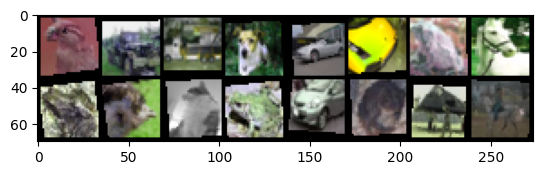

labels ['bird', 'truck', 'truck', 'dog', 'car', 'car', 'frog', 'horse', 'frog', 'bird']


In [3]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images))

print(f"labels {[classes[labels[i]] for i in range(10)]}")


Computation of loss and accuracy for given dataset loader and model. This will be used for computing loss and accuracy on the test set after each training epoch.

In [4]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            
    return running_loss/n, correct/total 

## Define model

In [5]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,64),     # with 32x32 input, the feature map size reduces to 5x5 with 16 channels.
    nn.ReLU(),
    nn.Linear(64,10)
)

for param in net.parameters():
    print(param.shape)
    

torch.Size([8, 3, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([64, 400])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


## Train model

In [6]:
nepochs = 50
#results_path = ROOT+'results/cnnclassifier50epochs.pt'
statsrec = np.zeros((4,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in train_loader:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
        
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total 
    ltst, atst = stats(test_loader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

results_dir_path = ROOT +'results'
if not os.path.exists(results_dir_path):
    os.makedirs(results_dir_path)
results_path = results_dir_path + os.sep + 'cnnclassifier50epochs.pt'
# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  2.118 training accuracy:  21.0%  test loss:  1.897 test accuracy:  31.2%
epoch: 1 training loss:  1.827 training accuracy:  33.7%  test loss:  1.578 test accuracy:  43.1%
epoch: 2 training loss:  1.669 training accuracy:  39.8%  test loss:  1.488 test accuracy:  46.1%
epoch: 3 training loss:  1.595 training accuracy:  42.5%  test loss:  1.438 test accuracy:  47.9%
epoch: 4 training loss:  1.540 training accuracy:  44.7%  test loss:  1.368 test accuracy:  50.7%
epoch: 5 training loss:  1.492 training accuracy:  46.4%  test loss:  1.367 test accuracy:  50.3%
epoch: 6 training loss:  1.451 training accuracy:  48.2%  test loss:  1.291 test accuracy:  53.7%
epoch: 7 training loss:  1.420 training accuracy:  49.2%  test loss:  1.240 test accuracy:  55.4%
epoch: 8 training loss:  1.382 training accuracy:  50.9%  test loss:  1.238 test accuracy:  56.5%
epoch: 9 training loss:  1.364 training accuracy:  51.8%  test loss:  1.219 test accuracy:  56.2%
epoch: 10 training l

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/results/cnnclassifier50epochs.pt'

Plot loss and accuracy on training and test sets

In [ ]:
#results_path = ROOT+'results/cnnclassifier50epochs.pt'
data = torch.load(results_path)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()